In [1]:
from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import torch.nn.functional as F
import torch.onnx
#import torchvision

from torch.utils.tensorboard import SummaryWriter

from mlagents_envs.base_env import ActionTuple

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
writer = SummaryWriter()

lr = 1e-5
clip_param = 0.2
lambd_param = 0.95
gamma_param = 0.99
num_epochs_list = [100]
num_episodes = 512
ppo_batch_size = 512
mini_batch_size = 64
ppo_epoch = 4 #conventionally, 4
entropy_coef_param = 0.01

input_channel = 23
action_size = 6


print(use_cuda)
print(device)

True
cuda


# Creating model(Actor-critic)

In [3]:
def print_shape_hook(module, input, output):
    print(f"{module.__class__.__name__}: {output.shape}")

In [4]:
#need to change the input size of linear layer

class Actor(nn.Module):
    def __init__(self, input_channel, action_dim):
        super(Actor, self).__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(input_channel, 96, 4, 4),
            nn.Conv2d(96, 96, 7),
            nn.Conv2d(96, 384, 1),
            nn.ReLU(),
            nn.Conv2d(384,96,1),
            nn.Conv2d(96, 192, 7),
            nn.Conv2d(192, 768,1),
            nn.ReLU(),
            nn.Conv2d(768, 192, 1),

            # add more Conv layers according to your input size of the image (more than 110 x 110)
            
            # nn.Conv2d(192, 384, 7),
            # nn.Conv2d(384, 1536, 1),
            # nn.ReLU(),
            # nn.Conv2d(1536, 384, 1),
            # nn.Conv2d(384, 768,7),
            # nn.Conv2d(768, 3072,1),
            # nn.ReLU(),
            # nn.Conv2d(3072, 768, 1),
            # nn.ReLU(),
        )

        # for conv_layer in self.convs:
        #     conv_layer.register_forward_hook(print_shape_hook)

        self.flatten = nn.Flatten()

        self.linear = nn.Linear(43200, action_dim)
        self.log_std = nn.Parameter(torch.ones((1,action_dim)))

    def forward(self, observation):
        x = self.convs(observation)
        x = self.flatten(x)
        logits = self.linear(x)

        std = self.log_std.exp().expand_as(logits)
        dist = Normal(logits, std)
        actions = dist.sample()

        actions_1_to_4 = actions[..., :4]
        actions_5_and_6 = actions[..., 4:]

        scaled_actions_1_to_4 = torch.tanh(actions_1_to_4)
        scaled_actions_5_and_6 = torch.sigmoid(actions_5_and_6)

        scaled_actions = torch.cat([scaled_actions_1_to_4, scaled_actions_5_and_6], dim=-1)
        
        log_probs = dist.log_prob(actions)
        entropy = dist.entropy()
        
        return scaled_actions, log_probs, entropy

    def reInstantiate_fc_layer_input_size(self, input_shape, output_shape=6):
        x = torch.randn(input_shape).to(device)
        with torch.no_grad():
            output = self.convs(x)

        flatten_output = output.view(1, -1).size(1)
        print(f"new fc layer input size: {flatten_output}")

        self.linear = nn.Linear(flatten_output, output_shape).to(device)


In [5]:
class Critic(nn.Module):
    def __init__(self, input_channel):
        super(Critic, self).__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(input_channel, 96, 4, 4),
            nn.Conv2d(96, 96, 7),
            nn.Conv2d(96, 384, 1),
            nn.ReLU(),
            nn.Conv2d(384,96,1),
            nn.Conv2d(96, 192, 7),
            nn.Conv2d(192, 768,1),
            nn.ReLU(),
            nn.Conv2d(768, 192, 1),

            # add more layers if input size of image is bigger than default(110 x 110)
            
            # nn.Conv2d(192, 384, 7),
            # nn.Conv2d(384, 1536, 1),
            # nn.ReLU(),
            # nn.Conv2d(1536, 384, 1),
            # nn.Conv2d(384, 768,7),
            # nn.Conv2d(768, 3072,1),
            # nn.ReLU(),
            # nn.Conv2d(3072, 768, 1),
            # nn.ReLU(),
        )

        # for layer in self.convs:
        #     layer.register_forward_hook(print_shape_hook)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(43200, 1)

    def forward(self, observation):
        x = self.convs(observation)
        x = self.flatten(x)
        value = self.linear(x)

        return value

    def reInstantiate_fc_layer_input_size(self, input_shape):
        x = torch.randn(input_shape).to(device)
        with torch.no_grad():
            output = self.convs(x)

        flatten_output = output.view(1, -1).size(1)
        print(f"new fc layer input size: {flatten_output}")

        self.linear = nn.Linear(flatten_output, output_shape).to(device)

# Initialize PPO and critic update

In [6]:
#calculate ppo loss for one agent
def calc_ppo_loss(ppo_epoch, batch_size, num_agents, states_agent1, states_agent2, log_probs_agent1, log_probs_agent2, entropy_agent1, entropy_agent2, advantages_agent1, advantages_agent2, sigma_param):

    assert len(states_agent1) == len(log_probs_agent1) == len(advantages_agent1) == len(entropy_agent1) == len(states_agent2) == len(log_probs_agent2) == len(advantages_agent2) == len(entropy_agent2) 
    def ppo_iter(mini_batch_size, 
                 batch_size, 
                 states_agent1, 
                 log_probs_agent1, 
                 entropy_agent1, 
                 advantages_agent1, 
                 states_agent2, 
                 log_probs_agent2, 
                 entropy_agent2, 
                 advantages_agent2
                ):
        for _ in range(batch_size // (mini_batch_size)):
            # Generate random indices for sampling
            batch_ids = np.random.randint(0, batch_size, mini_batch_size)
            
            # Yield the mini-batches of states and log probabilities for both agents
            yield (
                states_agent1[batch_ids, :, :, :],
                states_agent2[batch_ids, :, :, :],
                log_probs_agent1[batch_ids, :],
                log_probs_agent2[batch_ids, :],
                entropy_agent1[batch_ids, :],
                entropy_agent2[batch_ids, :],
                advantages_agent1[batch_ids],
                advantages_agent2[batch_ids]
            )

    for _ in range(ppo_epoch):
        for (
                state_agent1, state_agent2,
                log_probs_old_agent1, log_probs_old_agent2,
                entropys_old_agent1, entropys_old_agent2,
                advantage_agent1, advantage_agent2
            ) in ppo_iter(
                mini_batch_size, 
                batch_size,  
                states_agent1,  
                log_probs_agent1,  
                entropy_agent1, 
                advantages_agent1,
                states_agent2,
                log_probs_agent2,
                entropy_agent2,
                advantages_agent2
            ):
            
            
            _ , log_probs_new_agent1, entropy_new_agent1 = agent_model(state_agent1)
            _ , log_probs_new_agent2, entropy_new_agent2 = agent_model(state_agent2)
            
            rt_agent1 = (log_probs_new_agent1 - log_probs_old_agent1).exp()
            rt_agent2 = (log_probs_new_agent2 - log_probs_old_agent2).exp()
            
            clip_agent1 = torch.clamp(rt_agent1, 1 - clip_param, 1 + clip_param)
            clip_agent2 = torch.clamp(rt_agent2, 1 - clip_param, 1 + clip_param)
            
            surr1_agent1 = rt_agent1 * advantage_agent1.unsqueeze(1)
            surr2_agent1 = clip_agent1 * advantage_agent1.unsqueeze(1)

            surr1_agent2 = rt_agent2 * advantage_agent2.unsqueeze(1)
            surr2_agent2 = clip_agent2 * advantage_agent2.unsqueeze(1)
            
            
            agent1_loss = - torch.min(surr1_agent1, surr2_agent1).mean()
            entropy_aggre_agent1 = - entropy_new_agent1.mean()

            agent2_loss = - torch.min(surr1_agent2, surr2_agent2).mean()
            entropy_aggre_agent2 = - entropy_new_agent2.mean()
            
            
            loss = (agent1_loss + agent2_loss + sigma_param * (entropy_aggre_agent1 + entropy_aggre_agent2)) / num_agents
            
            agent_optimizer.zero_grad()
            loss.backward()
            agent_optimizer.step()
    

In [7]:
def mappo_update(ppo_epoch, batch_size, agents_name, states_all, log_probs_all, entropy_all, advantages_all, sigma_param):
    loss = 0
    num_agents = len(agents_name)
    agent1, agent2 = agents_name
    calc_ppo_loss(
        ppo_epoch, 
        batch_size, 
        num_agents, 
        states_all[agent1], 
        states_all[agent2], 
        log_probs_all[agent1], 
        log_probs_all[agent2], 
        entropy_all[agent1], 
        entropy_all[agent2], 
        advantages_all[agent1], 
        advantages_all[agent2], 
        sigma_param
    )


In [8]:
def calc_critic_loss(critic_update_epoch, batch_size, mini_batch_size, num_agents, states_agent1, states_agent2, values_agent1, values_agent2, returns_agent1, returns_agent2):
    def critic_loss_iter(batch_size, 
                         mini_batch_size, 
                         states_agent1, 
                         states_agent2,
                         values_agent1,
                         values_agent2,
                         returns_agent1,
                         returns_agent2,
                        ):
        for _ in range(batch_size // (mini_batch_size)):
            batch_ids = np.random.randint(0, batch_size, mini_batch_size)
            yield (
                states_agent1[batch_ids, :, :, :],
                states_agent2[batch_ids, :, :, :],
                values_agent1[batch_ids],
                values_agent2[batch_ids],
                returns_agent1[batch_ids, :],
                returns_agent2[batch_ids, :]
                
            )

    for _ in range(critic_update_epoch):
        for (
            state_agent1, 
            state_agent2, 
            values_old_agent1, 
            values_old_agent2, 
            return_agent1, 
            return_agent2) in critic_loss_iter(
            batch_size, 
            mini_batch_size, 
            states_agent1,
            states_agent2,
            values_agent1,
            values_agent2,
            returns_agent1,
            returns_agent2
        ):
            value_new_agent1 = critic_model(state_agent1)
            value_new_agent2 = critic_model(state_agent2)

            surr1_agent1 = (value_new_agent1 - return_agent1).pow(2).mean()
            surr2_agent1 = (torch.clamp(value_new_agent1, values_old_agent1 - clip_param, values_old_agent1 + clip_param) - return_agent1).pow(2).mean()

            surr1_agent2 = (value_new_agent2 - return_agent2).pow(2).mean()
            surr2_agent2 = (torch.clamp(value_new_agent2, values_old_agent2 - clip_param, values_old_agent2 + clip_param) - return_agent2).pow(2).mean()

            critic_loss_agent1 = max(surr1_agent1, surr2_agent1)

            critic_loss_agent2 = max(surr1_agent2, surr2_agent2)
            loss = (critic_loss_agent1 + critic_loss_agent2) / num_agents
            
            critic_optimizer.zero_grad()
            loss.backward()
            critic_optimizer.step()
        


In [9]:
def critic_update(critic_update_epoch, batch_size, mini_batch_size, agents_name, states_all, values_all, returns_all):
    num_agents = len(agents_name)
    agent1, agent2 = agents_name
    calc_critic_loss(critic_update_epoch, 
                     batch_size, 
                     mini_batch_size, 
                     num_agents, 
                     states_all[agent1], 
                     states_all[agent2],
                     values_all[agent1],
                     values_all[agent2],
                     returns_all[agent1], 
                     returns_all[agent2]
                    )

# GAE for estimating Advantage function

Here, we used GAE to estimate reward-to-go by using equation Q = A(estimated) + V 

In [10]:
#this method is for lambd = 1 in TD(lambd) algorithm
def compute_GAE(next_value, values, rewards, gamma, lambd):
    gae = 0
    returns = []
    values = values if len(next_value) == 0 else values + [next_value]
    if len(values) == len(rewards) + 1:
        for step in reversed(range(len(rewards))):
            delta = rewards[step] + (gamma * values[step + 1]) - values[step]
            if step == len(rewards) - 1:
                gae = 0
            else:
                gae = delta + gamma * lambd * gae

            returns.append(gae + values[step])
    else:
        for step in reversed(range(1, len(values))):
            delta = rewards[step - 1] + (gamma * values[step]) - values[step - 1]
            if step == len(values) - 1:
                gae = 0
            else:
                gae = delta + gamma * lambd * gae
    
            returns.append(gae + values[step])
            
    returns.reverse()
    return returns


In [11]:
def compute_GAE_dict(next_values, values_all, rewards_all, gamma, lambd):
    agents_name = ["agent1", "agent2"]
    returns_all = {"agent1": [], "agent2": []}
    for index, agent_name in enumerate(agents_name):
        returns_all[agent_name] = compute_GAE(next_values[index], values_all[agent_name], rewards_all[agent_name], gamma, lambd)

    return returns_all

In [12]:
def compute_Advantage_dict(values_all, returns_all):
    advantages_all = {"agent1": [], "agent2": []}
    agents_name = ["agent1", "agent2"]

    for agent_name in agents_name:
        for i in range(len(returns_all[agent_name])):
            advantages_all[agent_name].append(returns_all[agent_name][i] - values_all[agent_name][i])

    return advantages_all

In [13]:
values_all = {"agent1": torch.Tensor([1,1,1,1]), "agent2": [1,1,1,3]}
returns_all = {"agent1": torch.Tensor([1,3,5,1]), "agent2": np.array([1,4,5,6])}

advantages_all_dummy = compute_Advantage_dict(values_all, returns_all)

In [14]:
advantages_all_dummy

{'agent1': [tensor(0.), tensor(2.), tensor(4.), tensor(0.)],
 'agent2': [0, 3, 4, 3]}

# Config and constant setups

In [15]:
_actor_visual_obs_from_env = [
        #LAYER ORDER
        "CameraSensor",
        "AgentSensor",
        "TableSensor",
        "OnionDispSensor",
        "DishDispSensor",
        "ServeDispSensor",
        "OvenDispSensor",
        "OnionSensor",
        "DishSensor",
        "SoupSensor",
        "CookingTimerSensor",
        "IsCookedSensor"
    ]

agent_movement_directions = ["LEFT", "RIGHT", "UP", "DOWN"]


sorted_obs_order = [   
        "CameraSensor_1",
        "CameraSensor_2",
        "CameraSensor_3",
        "AgentSensor",
        "AgentSensor_UP",
        "AgentSensor_DOWN",
        "AgentSensor_RIGHT",
        "AgentSensor_LEFT",
        "OtherAgentSensor",
        "OtherAgentSensor_UP",
        "OtherAgentSensor_DOWN",
        "OtherAgentSensor_RIGHT",
        "OtherAgentSensor_LEFT",
        "TableSensor",
        "OnionDispSensor",
        "DishDispSensor",
        "ServeDispSensor",
        "OvenDispSensor",
        "OnionSensor",
        "DishSensor",
        "SoupSensor",
        "CookingTimerSensor",
        "IsCookedSensor"
    ]


In [16]:
def setupUnityEnv(url:str = None, time_scale:float = 20.0):
    # Optional: Set up engine configurations like rendering and time scale
    engine_channel = EngineConfigurationChannel()
    engine_channel.set_configuration_parameters(time_scale=time_scale) # Faster simulation

    # Initialize the Unity environment with the executable
    env = UnityEnvironment(file_name=url, side_channels=[engine_channel])
    env.reset()  # Start a new episode

    return env


In [17]:
def addDirectionLayer(layer_dict,direction_obs):
    x_axis, y_axis = direction_obs.squeeze(0)

    for direction in agent_movement_directions:
        layer_initailize = np.zeros_like(layer_dict["AgentSensor"])
        layer_dict[f"AgentSensor_{direction}"] = layer_initailize

    def chooseDirectionLayer(axis, axis_name):
        direct = {
            "x": ["LEFT", "RIGHT"],
            "y":["DOWN", "UP"]
        }
        direction = str()
        if axis < 0:
            direction = direct[axis_name][0]
        elif axis > 0:
            direction = direct[axis_name][1]
        else:
            direction = None

        return direction
    
    agent_directions = [chooseDirectionLayer(x_axis, "x"), chooseDirectionLayer(y_axis,"y")]
    
    for agent_direction in agent_directions:
        if agent_direction is None:
            continue

        layer_visual_vector = layer_dict["AgentSensor"]
        layer_dict[f"AgentSensor_{agent_direction}"] = layer_visual_vector
    
    return layer_dict


In [18]:
def addOtherAgentLayers(layer_dict,agent_name,other_agent_name):
    other_agent_layer_names = {
        "OtherAgentSensor": "AgentSensor",
        "OtherAgentSensor_UP": "AgentSensor_UP",
        "OtherAgentSensor_DOWN": "AgentSensor_DOWN",
        "OtherAgentSensor_RIGHT": "AgentSensor_RIGHT",
        "OtherAgentSensor_LEFT":"AgentSensor_LEFT"
    }

    for key, value in other_agent_layer_names.items():
        layer_dict[agent_name][key] = layer_dict[other_agent_name][value]

    return layer_dict[agent_name]
            

# instantiate Actor and Critic model


In [19]:
agent_model = Actor(23, 6).to(device)
critic_model = Critic(23).to(device)

agent_optimizer = optim.Adam(agent_model.parameters(), lr=lr)
critic_optimizer = optim.Adam(critic_model.parameters(), lr=lr)

for param in agent_model.parameters():
    param.requires_grad = True

print(agent_model)
print(critic_model)


Actor(
  (convs): Sequential(
    (0): Conv2d(23, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1))
    (2): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(384, 96, kernel_size=(1, 1), stride=(1, 1))
    (5): Conv2d(96, 192, kernel_size=(7, 7), stride=(1, 1))
    (6): Conv2d(192, 768, kernel_size=(1, 1), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(768, 192, kernel_size=(1, 1), stride=(1, 1))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=43200, out_features=6, bias=True)
)
Critic(
  (convs): Sequential(
    (0): Conv2d(23, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1))
    (2): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(384, 96, kernel_size=(1, 1), stride=(1, 1))
    (5): Conv2d(96, 192, kernel_size=(7, 7), stride=(1, 1))
    (6): Conv2d(192, 768, kernel_size=(1, 1), stride=(1,

In [20]:
def reset_params(model):
    for layer in model.modules():
        if hasattr(layer, "reset_parameters"):
            layer.reset_parameters()
        else:
            continue

In [21]:
def print_all_agent_trajectory(trajectory: dict(), feature_name):
    print(f"{feature_name}: \n")
    print("agent1")
    print(trajectory["agent1"].shape if type(trajectory["agent1"]) == np.ndarray else type(trajectory["agent1"]))
    print("agent2")
    print(trajectory["agent2"].shape if type(trajectory["agent2"]) == np.ndarray else type(trajectory["agent2"]))
    

In [22]:
def transfer_to_numpy(dictionary: dict):
    if type(dictionary["agent1"]) is torch.Tensor or type(dictionary["agent2"]) is torch.Tensor:
        numpy_array1, numpy_array2 = dictionary["agent1"].numpy(force=True), dictionary["agent2"].numpy(force=True)
    else:
        numpy_array1, numpy_array2 = np.array(dictionary["agent1"], dtype=np.float32), np.array(dictionary["agent2"], dtype=np.float32)
        
    numpy_dictionary = {"agent1": numpy_array1, "agent2": numpy_array2}
    return numpy_dictionary

In [23]:
decision_steps_dummy = [1,1,1]
terminal_steps_dummy = [1,]
dones_dummy = []

dones_dummy.append(0 if len(terminal_steps_dummy) == 0 else 1)

In [24]:
def concat_tensor_dict(trajectory_dict):
    tensor_dict = dict()
    for key, value in trajectory_dict.items():
        tensor_dict[key] = torch.cat(value)
    return tensor_dict

In [25]:
def convert_list_into_tensor_dict(trajectory_dict):
    tensor_dict = dict()
    for key, value in trajectory_dict.items():
        tensor_dict[key] = torch.stack(value)
    return tensor_dict

In [26]:
def calc_total_reward(rewards_all):
    total_rewards = []
    for key, value in rewards_all.items():
        reward_plus = 0
        for index, reward_agent in enumerate(value):
            if reward_agent > 0:
                # print(f'index: {index}, reward_agent1: {reward_agent}')
                reward_plus = reward_plus + reward_agent
        total_rewards.append(reward_plus)

    return total_rewards

In [27]:
dict_dummy = {"agent1": [torch.tensor([[1.0], [2.5]]), torch.tensor([[3.0], [4.0]])]}

tensor_dummy = concat_tensor_dict(dict_dummy)

In [28]:
tensor_dummy

{'agent1': tensor([[1.0000],
         [2.5000],
         [3.0000],
         [4.0000]])}

In [29]:
total_rewards_all = []

In [30]:
def main():
    # Set up the path to the Unity executable
    env_path = "../CAIPlatform/Build/v2-2/platform_v2_2_dualAgent.x86_64"  # Replace with your actual build path

    env = setupUnityEnv(env_path)
    env.reset()
    
    # Set up to interact with the environment

    agent_names = list(env.behavior_specs)
    agent1, agent2 = agent_names
    print(f"Agents: {list(env.behavior_specs)}")
    print(type(env.behavior_specs))
    for num_epochs in num_epochs_list:
        
        agent_model = Actor(23, 6).to(device)
        critic_model = Critic(23).to(device)
        
        agent_optimizer = optim.Adam(agent_model.parameters(), lr=lr)
        critic_optimizer = optim.Adam(critic_model.parameters(), lr=lr)
        
        for param in agent_model.parameters():
            param.requires_grad = True

        total_rewards_epochs = []
        
        for num_epoch in range(num_epochs):
            states_agent1 = []  # Observations for Agent 1
            states_agent2 = []  # Observations for Agent 2
            
            states_all = {"agent1": [], "agent2": []}
            actions_all = {"agent1": [], "agent2": []}
            log_probs_all = {"agent1": [],"agent2": [] }
            entropy_all = {"agent1": [], "agent2": []}
            values_all = {"agent1": [], "agent2": []}
            rewards_all = {"agent1": [], "agent2": []}
            
            returns_all = dict()  # Returns calculated for the trajectory
            advantages_all = dict()  # Advantage estimates for PPO
            
            dones = []  # Whether the episode ended at this step
            terminal_info = {"terminal_steps": list(), "observation_specs": None, "agent_name": str(), "other_agent": str()}
            terminal_steps = None
            
            env.reset()
            
            for num_episode in range(num_episodes):
                
                agents_obs = dict()
                agents_obs_in_array = []
                for index, agent_name in enumerate(agent_names):
                    spec = env.behavior_specs[agent_name]
            
                    decision_steps, terminal_steps = env.get_steps(agent_name)
                    
                    dones.append(0 if len(terminal_steps) == 0 else 1)
                    if dones[-1] == 1:
                        terminal_info["terminal_steps"] = terminal_steps
                        terminal_info["observation_specs"] = spec.observation_specs
                        terminal_info["agent_name"] = agent_name
                        terminal_info["other_agent"] = agent1 if agent1 != agent_name else agent2
                        break
                    
                    for agent_id in decision_steps.agent_id_to_index:
                        reward = decision_steps[agent_id].reward
                        # print(f"Agent {agent_id} reward: {reward}")
                        rewards_all[f"agent{agent_id + 1}"].append(reward)
                        
                    
                    # visual_obs, direction = sort_obs_from_env(spec.observation_specs)
                    
                    temp_input = dict()
                        
                    for index, obs_step in enumerate(spec.observation_specs):
                        
                        if len(obs_step.shape) == 3:
                            if obs_step.name == "CameraSensor":
                                for idx in range(len(decision_steps.obs[index].squeeze(0) )):
                                    temp_input[f"{obs_step.name}_{idx + 1}"] = decision_steps.obs[index].squeeze(0)[idx]
                            else:
                                temp_input[obs_step.name] = decision_steps.obs[index].squeeze(0).squeeze(0)
            
                            
                        else:
                            temp_input = addDirectionLayer(temp_input, decision_steps.obs[index])
                
                    agents_obs[agent_name] = temp_input
                
                if dones[-1] == 1:
                    break
                    
                agents_obs[agent1]= addOtherAgentLayers(agents_obs, agent1, agent2)
                agents_obs[agent2] = addOtherAgentLayers(agents_obs, agent2, agent1)
            
                #input dictionary -> sorted array (as sorted_obs_order)
                for agent_name in agent_names:
                    agent_obs_in_array = []
                    for sorted_layer in sorted_obs_order:
                        agent_obs_in_array.append(agents_obs[agent_name][sorted_layer])
                    agents_obs_in_array.append(agent_obs_in_array)
                
                #array -> numpy array 
                agents_obs_in_array = np.array(agents_obs_in_array, dtype=np.float32)
                #obs -> state (save it for later)
                # sprint(agents_obs_in_array.shape)
                agents_obs_in_array = torch.from_numpy(agents_obs_in_array).to(device)
                states_agent1.append(agents_obs_in_array[0])
                states_agent2.append(agents_obs_in_array[1])
                
                actions, log_probs, entropy = agent_model(agents_obs_in_array)
                values = critic_model(agents_obs_in_array)
                
                for index, agent_name in enumerate(agent_names):
                    actions_all[f"agent{index + 1}"].append(actions[index].detach().cpu().numpy())
                    log_probs_all[f"agent{index + 1}"].append(log_probs[index].detach())
                    entropy_all[f"agent{index + 1}"].append(entropy[index].detach())
                    values_all[f"agent{index + 1}"].append(values[index].detach())
                    
                    agent_action_tensor = actions[index].unsqueeze(0)
                    action_tuple = ActionTuple(continuous=agent_action_tensor.numpy(force=True))
                    env.set_actions(agent_name, action_tuple)
                    
                env.step()
                
    
            #compute adavantage function with GAE here (this is why i cannot detach it at the same place with the others)
    
            # print(f'terminal_info:[terminal_steps: {terminal_info["terminal_steps"] is not None}, \n observation_specs:{terminal_info["observation_specs"] is not None}, \n agent_name: {terminal_info["agent_name"]} \n other_agent: {terminal_info["other_agent"]}')
            
            if len(terminal_info["terminal_steps"]) > 0:
                agents_obs = dict()
                agents_obs_in_array = []
                temp_input = dict()
                        
                for index, obs_step in enumerate(terminal_info["observation_specs"]):
                    
                    print(f'obs_name: {obs_step.name}, shape: {terminal_info["terminal_steps"].obs[index].shape}, obs_step.shape: {obs_step.shape}')
                    if len(obs_step.shape) == 3:
                        if obs_step.name == "CameraSensor":
                            for idx in range(len(terminal_info["terminal_steps"].obs[index].squeeze(0) )):
                                temp_input[f"{obs_step.name}_{idx + 1}"] = terminal_info["terminal_steps"].obs[index].squeeze(0)[idx]
                        else:
                            temp_input[obs_step.name] = terminal_info["terminal_steps"].obs[index].squeeze(0).squeeze(0)
                        
                    else:
                        temp_input = addDirectionLayer(temp_input, terminal_info["terminal_steps"].obs[index])
                        print(f'other observation: {terminal_info["terminal_steps"].obs[index].shape}')
            
                agents_obs[terminal_info["agent_name"]] = temp_input
    
                print(agents_obs[terminal_info["agent_name"]].keys())
                print("cannot use this due to my lack of skills...")
                next_values = []
                
            else:
                
                agents_obs = dict()
                agents_obs_in_array = []
                for index, agent_name in enumerate(agent_names):
                    spec = env.behavior_specs[agent_name]
            
                    decision_steps, terminal_steps = env.get_steps(agent_name)
                    
                    temp_input = dict()
                        
                    for index, obs_step in enumerate(spec.observation_specs):
                        
                        if len(obs_step.shape) == 3:
                            # print(f"obs_name: {obs_step.name}, shape: {decision_steps.obs[index].shape}")
                            if obs_step.name == "CameraSensor":
                                for idx in range(len(decision_steps.obs[index].squeeze(0) )):
                                    temp_input[f"{obs_step.name}_{idx + 1}"] = decision_steps.obs[index].squeeze(0)[idx]
                            else:
                                temp_input[obs_step.name] = decision_steps.obs[index].squeeze(0).squeeze(0)
            
                            
                        else:
                            temp_input = addDirectionLayer(temp_input, decision_steps.obs[index])
                            # print(f"other observation: {decision_steps.obs[index].shape}")
                
                    agents_obs[agent_name] = temp_input
                    
                agents_obs[agent1]= addOtherAgentLayers(agents_obs, agent1, agent2)
                agents_obs[agent2] = addOtherAgentLayers(agents_obs, agent2, agent1)
            
                #input dictionary -> sorted array (as sorted_obs_order)
                for agent_name in agent_names:
                    agent_obs_in_array = []
                    for sorted_layer in sorted_obs_order:
                        agent_obs_in_array.append(agents_obs[agent_name][sorted_layer])
                    agents_obs_in_array.append(agent_obs_in_array)
                
                agents_obs_in_array = np.array(agents_obs_in_array, dtype=np.float32)
                
                agents_obs_in_array = torch.from_numpy(agents_obs_in_array).to(device)
    
                next_values = critic_model(agents_obs_in_array)
                
            returns_all = compute_GAE_dict(next_values, values_all, rewards_all, gamma_param, lambd_param)
            
            assert len(values_all["agent1"]) == len(returns_all["agent1"]) 
            
            advantages_all = compute_Advantage_dict(values_all, returns_all)
            
            states_all["agent1"], states_all["agent2"] = states_agent1, states_agent2
    
            #convert list into tensor for ppo
            states_all = convert_list_into_tensor_dict(states_all)
            log_probs_all = convert_list_into_tensor_dict(log_probs_all) 
            entropy_all = convert_list_into_tensor_dict(entropy_all)
            values_all = concat_tensor_dict(values_all)
            returns_all = convert_list_into_tensor_dict(returns_all)
            advantages_all = concat_tensor_dict(advantages_all)
            
            agent1_str = "agent1"
            agent2_str = "agent2"

            total_rewards_epochs.append(calc_total_reward(rewards_all))
            # print(f"epoch {num_epoch}: total_rewards = {total_rewards_epochs[-1]}")
            
            num_agents = len(agent_names)
    
            dict_keys = ["agent1", "agent2"]
            mappo_update(ppo_epoch, ppo_batch_size, dict_keys, states_all, log_probs_all, entropy_all, advantages_all, entropy_coef_param)    
            critic_update(ppo_epoch, ppo_batch_size, mini_batch_size, dict_keys, states_all, values_all, returns_all)

        total_rewards_all.append(total_rewards_epochs)
        
        onnx_file_path = f"agent_model_param_{str(num_epochs)}_epochs.onnx"
        torch.onnx.export(
            agent_model,
            states_all["agent1"][0].unsqueeze(0),
            onnx_file_path,
            export_param=True,
            opset_version=11,
            do_constant_folding=True,
            input_names=["input"],
            output_names=["output"],
        )
            
    # for epoch, rewards in enumerate(total_rewards_all):
    #     print(f"epoch: {epoch}, rewards: {rewards}")
    
    env.close()

In [31]:
a = torch.from_numpy(np.random.random([2,6]))
print(a[0].unsqueeze(0).shape)

torch.Size([1, 6])


In [32]:
main()

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

In [33]:
total_rewards_all

[[[6.0, 6.0]]]

In [34]:
print(len(total_rewards_all))
print(len(total_rewards_all[0]))

1
1


In [35]:
import matplotlib.pyplot as plt

In [36]:
def plot_and_save_graph(total_rewards_all):
    for total_reward in total_rewards_all:
        flat_data = total_reward  # Now it's (300, 2)
        
        # Create X-axis (indices 0 to 299)
        x = list(range(len(total_reward)))
        
        # Extract the two Y-axis series
        y1 = [pair[0] for pair in flat_data]  # First value in each pair
        y2 = [pair[1] for pair in flat_data]  # Second value in each pair
        
        # Plot the data
        plt.plot(x, y1, label="total rewards (agent1)", color='blue')
        plt.plot(x, y2, label="total rewards (agent2)", color='orange')
        
        # Customize the graph
        plt.title("Total rewards of each agent")
        plt.xlabel("epoch")
        plt.ylabel("total rewards")
        plt.legend()
        plt.grid(True)
        
        plt.savefig(f"graph_output_{len(total_reward)}_epochs.png", dpi=800, format='png')  # Save as PNG with 300 DPI
        
        
        # Display the graph
        plt.show()

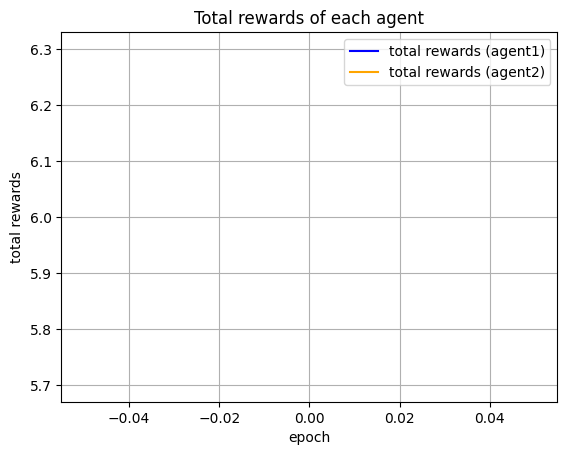

In [37]:
plot_and_save_graph(total_rewards_all)